## Federated Learning Tutorial: Launching the Server


<img src="https://github.com/APPFL/APPFL/blob/main/docs/_static/logo/logo_small.png?raw=true" width="40%" alt="APPFL Logo">


In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning server for orchestrating federated learning experiments between two distributed clients, whose client-launching code are available in your jupyter workspace as **Client1 (APPFL_Client1_IXI.ipynb)** and **Client2 (APPFL_Client2_IXI.ipynb)**.

This example will train a simple UNet using T1-weighted brain MRI images from two hospitals, HH and IOP, to do brain segmentation.


### 1. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

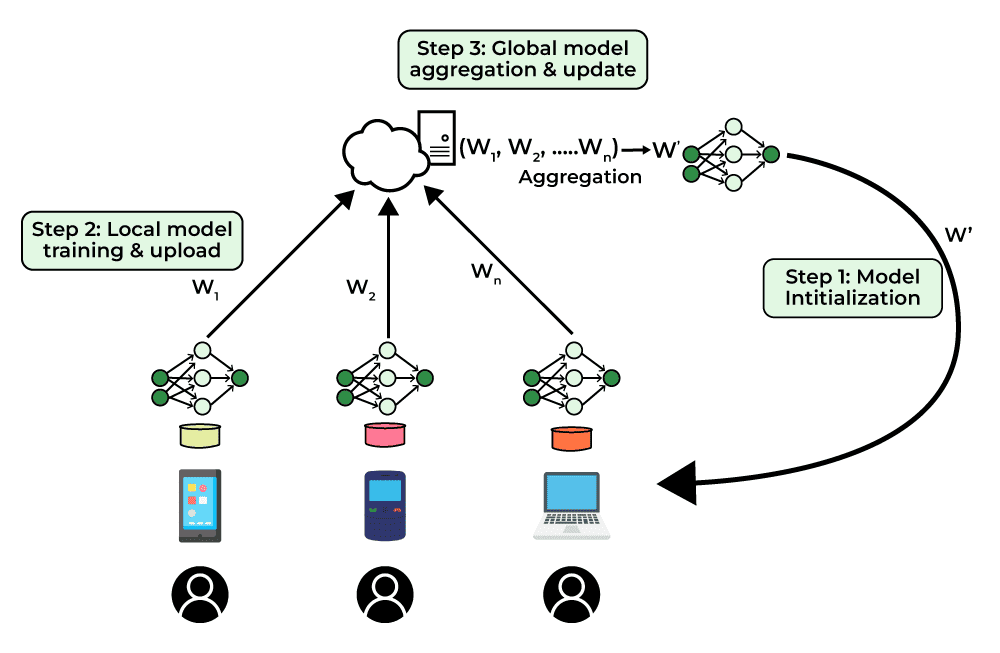

### 2. Create federated learning server agent from configurations

Here we print the configurations needed to create a federated learning server. Specifically, it is composed of two main parts: `client_configs` and `server_configs`.

The `client_configs` mainly contains **general** configurations that should be the same among all clients (e.g., training configurations, model architectures). Those configurations will be shared will all the clients at the beginning of experiments. This can avoid having each client to set the same configurations themselves separately. In this example, `client_configs` has two main components:

- `client_configs.train_configs`: This component contains configurations related to client's local training, such as the trainer to use, loss function, validation function, etc.

- `client_configs.model_configs`: This provides the path which defines the python function to load the architecture of the model to be trained.


The `server_configs` contains configurations that are specific to the federated learning server, such as the number of global epochs (total communication rounds between server and clients), and aggregators to use, etc.


 If you are interested, you can find more detailed explanations for the meanings of different configuration fields at [APPFL's official document](https://appfl.ai/en/latest/users/server_agent.html#configurations).

In [1]:
# [WARNING]: Please only run this cell ONCE at the beginning of your script.
# First: Change the working directory to the root of the repository and ignore warnings
import os
import warnings

os.chdir("../..")
warnings.filterwarnings("ignore")

In [2]:
# Set seed for reproducibility
import torch
import random
import numpy as np

seed_value = 1

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from omegaconf import OmegaConf
from appfl.agent import ServerAgent

server_agent_config = OmegaConf.load(
    "./resources/configs/flamby/ixi/server_fedavg.yaml"
)

print("==========Server Configuration==========")
print(OmegaConf.to_yaml(server_agent_config))
print("========================================")
server_agent = ServerAgent(server_agent_config=server_agent_config)

appfl: ✅[2025-06-26 13:30:54,087 server]: Logging to ./output/result_Server_2025-06-26-13-30-54.txt


==========Server Configuration==========
client_configs:
  train_configs:
    trainer: VanillaTrainer
    mode: step
    num_local_steps: 50
    optim: AdamW
    optim_args:
      lr: 0.001
    loss_fn_path: ./resources/loss/flamby_ixi.py
    loss_fn_name: BaselineLoss
    do_validation: true
    do_pre_validation: true
    metric_path: ./resources/metric/flamby_ixi.py
    metric_name: metric
    use_dp: false
    train_batch_size: 2
    val_batch_size: 2
    train_data_shuffle: true
    val_data_shuffle: false
  model_configs:
    model_path: ./resources/model/unet.py
    model_name: Baseline
server_configs:
  num_clients: 2
  scheduler: SyncScheduler
  scheduler_kwargs:
    same_init_model: true
  aggregator: FedAvgAggregator
  aggregator_kwargs:
    client_weights_mode: equal
  num_global_epochs: 10
  logging_output_dirname: ./output
  logging_output_filename: result
  comm_configs:
    grpc_configs:
      server_uri: 0.0.0.0:50051
      max_message_size: 1048576
      use_ssl: fals

### 3. gRPC server communicator creation

In this step, we create a server communicator that facilitates communication between the server and its clients using gRPC. It provides a reliable medium for the server and clients to exchange information efficiently and asynchronously.

**The following code block will print out a link that you need to copy to your two client notebooks.**

In [4]:
import socket
from appfl.comm.grpc import GRPCServerCommunicator

# Start the gRPC server communicator
communicator = GRPCServerCommunicator(
    server_agent,
    logger=server_agent.logger,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

#Getting the private IP address of the server
hostname = socket.gethostname()
private_ip = socket.gethostbyname(hostname)
print(f"\n\n✅ Replace server_uri with below in client notebook: {private_ip}:50051")



✅ Replace server_uri with below in client notebook: 192.168.1.121:50051


### 4. Launch the Server

Finally, you can use the communicator to start serving the FL server, which will handle different requests from the two clients to finish the FL experiments.

The client training results are logged in real time as a dictionary containing metrics such as `pre_val_accuracy` and `pre_val_loss` (accuracy and loss before each client's local training round) and `val_accuracy` and `val_loss` (accuracy and loss afterward). You will observe an increase in the model accuracy as the training proceeds.

In [5]:
from appfl.comm.grpc import serve

serve(
    communicator,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

appfl: ✅[2025-06-26 13:31:31,932 server]: Received GetConfiguration request from client Client2
appfl: ✅[2025-06-26 13:31:31,989 server]: Received GetGlobalModel request from client Client2
appfl: ✅[2025-06-26 13:31:58,375 server]: Received GetConfiguration request from client Client1
appfl: ✅[2025-06-26 13:31:58,430 server]: Received GetGlobalModel request from client Client1
I0000 00:00:1750959178.504006 13174068 chttp2_transport.cc:1205] ipv6:%5B::1%5D:64402: Got goaway [11] err=UNAVAILABLE:GOAWAY received; Error code: 11; Debug Text: ping_timeout {created_time:"2025-06-26T13:32:58.504-04:00", http2_error:11, grpc_status:14}
appfl: ✅[2025-06-26 13:33:48,853 server]: Received UpdateGlobalModel request from client Client1
appfl: ✅[2025-06-26 13:33:48,855 server]: Received the following meta data from Client1:
{'pre_val_accuracy': 0.46323132514953613,
 'pre_val_loss': 0.5367775360743204,
 'round': 1,
 'val_accuracy': 0.47138261795043945,
 'val_loss': 0.5285580618339673}
appfl: ✅[2025-0

appfl: ✅[2025-06-23 21:44:15,405 server]: Terminating the server ...


## Improve Model Performance by Data Readiness Evaluation

Data quality is essential for the performance of trained AI models. Now, we leverage the Customizable Assurance of Data REadiness (CADRE) module to improve the data quality of two clients' local training data. The CADRE module defines metrics used to measure the data quality, the rules the measured metric are supposed to follow, and the remedy action to take for data that do not follow the rules. For more detailed information on how to use and configure the CADRE module, please refer to [this tutorial](https://appfl.ai/en/latest/tutorials/examples_dr_integration.html). In this case study, we defined a CADRE module to remove images with noisy samples from the clients' local dataset.

In addition to data preprocessing based on CADRE, we also generate a data readiness report for the processed data here.

### 1. Create a new server agent with data readiness configurations

In [20]:
server_agent_config = OmegaConf.load(
    "./resources/configs/flamby/ixi/server_fedavg_with_dr.yaml"
)

print("==========Server Configuration==========")
print(OmegaConf.to_yaml(server_agent_config))
print("========================================")
server_agent = ServerAgent(server_agent_config=server_agent_config)

==========Server Configuration==========
client_configs:
  train_configs:
    trainer: VanillaTrainer
    mode: step
    num_local_steps: 50
    optim: AdamW
    optim_args:
      lr: 0.001
    loss_fn_path: ./resources/loss/flamby_ixi.py
    loss_fn_name: BaselineLoss
    do_validation: true
    do_pre_validation: true
    metric_path: ./resources/metric/flamby_ixi.py
    metric_name: metric
    use_dp: false
    train_batch_size: 2
    val_batch_size: 2
    train_data_shuffle: true
    val_data_shuffle: false
  data_readiness_configs:
    generate_dr_report: true
    output_dirname: ./output
    output_filename: data_readiness_report
    dr_metrics:
      class_imbalance: false
      sample_size: false
      num_classes: false
      data_shape: false
      completeness: false
      data_range: false
      sparsity: false
      variance: false
      skewness: false
      entropy: false
      kurtosis: false
      class_distribution: false
      brisque: false
      sharpness: false
  

#### **Data Readiness Configurations**

As shown above, there is a separate configuration block under `client_configs` called `data_readiness_configs`. This configuration allows us to enable standard **data readiness metrics** and **visualizations** that are available by default.

When enabled, the specified metrics are used to evaluate each client's data **before training begins**. These evaluations are performed locally on the client's edge device, ensuring data privacy. The evaluation results are then transmitted to the server, where they are aggregated into a **Data Readiness Report**.

---

##### Why This Matters

This feature is a valuable addition to our framework, as it helps assess the quality and readiness of the data **prior to initiating the training phase**. Key benefits include:

- **Privacy-Preserving**: Data never leaves the edge device—only the metric results are shared.
- **Resource Efficiency**: Avoids wasting compute on poor-quality data.
- **Actionable Insights**: Provides users with a clear view of their data’s readiness, enabling them to decide whether:
  - Training should proceed.
  - Data cleaning or preprocessing is required on edge devices.

By evaluating data readiness upfront, we ensure that training is both efficient and effective.

For this example let's enable the following standard data readiness metrics and visualizations:


In [21]:
server_agent_config.client_configs.data_readiness_configs.dr_metrics.sample_size = True
server_agent_config.client_configs.data_readiness_configs.dr_metrics.data_shape = True
server_agent_config.client_configs.data_readiness_configs.dr_metrics.data_range = True
server_agent_config.client_configs.data_readiness_configs.dr_metrics.combine.feature_space_distribution = True

#### **Customizable Assurance of Data Readiness (CADRE)**

Another key feature integrated into **APPFL** is the ability for users to define **custom data readiness metrics, rules, and remedies**. This level of customization is crucial because data characteristics can vary significantly based on:

- The **modality** of the data (e.g., text, image, sensor)
- The **downstream task** (e.g., classification, regression)
- The **domain** (e.g., healthcare, finance, IoT)

To support this, APPFL introduces **Customizable Assurance of Data Readiness (CADRE)**.

---

#### What is CADRE?

CADRE allows users to plug in their own logic for assessing and improving data quality at the client level. A custom CADRE module includes three main functions:

- `metric()`: Define your own data readiness metric.
- `rule()`: Specify logic or thresholds that determine if the data passes.
- `remedy()`: Suggest or perform actions to improve the data quality if the rules are not met.

> 📄 **Documentation & Code:** [Data Readiness Assurance Framework in APPFL](https://appfl.ai/en/latest/tutorials/examples_dr_integration.html)

---

#### How It Works

Users can extend a `BaseCADREModule` and define their own `metric()`, `rule()`, and `remedy()` functions. Once defined, they can update the configuration via the `cadremodule_configs` field inside the `data_readiness_configs`.

The final **Data Readiness Report** will include results from both:
- The **standard metrics**, and
- The **custom CADRE modules**

This combined report helps users easily understand and address data readiness issues across all clients.

---

#### Example: Noise Handling CADRE Module

We’ve already implemented a custom CADRE module designed to **detect and remove noisy samples** in each edge client’s dataset. Below is the implementation:

```python import torch
from appfl.misc.data_readiness import BaseCADREModule


class CADREModuleNoise(BaseCADREModule):
    def __init__(self, train_dataset, **kwargs):
        """
        Initialize the CADREModuleNoise class, specializing in noise detection with configurable parameters.

        Args:
        - train_dataset: The dataset used for training.
        - kwargs: Additional keyword arguments for customization.
        """
        super().__init__(train_dataset, **kwargs)

    def metric(self, **kwargs):
        """
        Compute the mean magnitude of the data samples.

        Returns:
        - A dictionary containing:
            - "mean": The mean magnitude of the dataset samples.
            - "magnitudes": A list of magnitudes for each sample in the dataset.
        """
        # Check if the dataset has a 'data_input' attribute; otherwise, process the dataset.
        if hasattr(self.train_dataset, "data_input"):
            data_input = self.train_dataset.data_input
        else:
            # Stack input data from the dataset.
            data_input = torch.stack(
                [input_data for input_data, _ in self.train_dataset]
            )

        # Compute the magnitude of each sample.
        magnitudes = [torch.mean(sample[0] ** 2).item() for sample in data_input]
        # Calculate the mean of the magnitudes.
        mean = sum(magnitudes) / len(magnitudes)

        return {"mean": round(mean, 2), "magnitudes": magnitudes}

    def rule(self, metric_result, noise_threshold=2):
        """
        Apply a rule to identify noisy samples based on a noise threshold.

        Args:
        - metric_result: A dictionary containing computed metric results.
        - noise_threshold: Threshold below which samples are considered non-noisy.

        Returns:
        - A list of indices of samples considered noisy.
        """
        # Identify indices of samples with magnitudes below the noise threshold.
        noisy_indices = [
            i
            for i, mag in enumerate(metric_result["magnitudes"])
            if mag < noise_threshold
        ]
        return noisy_indices

    def remedy(self, metric_result, logger, **kwargs):
        """
        Apply a remedy by filtering out samples without noise.

        Args:
        - metric_result: Dictionary with computed magnitudes.
        - logger: Logger instance for logging modifications.
        - kwargs: Additional keyword arguments for customization.

        Returns:
        - A dictionary containing:
            - "ai_ready_dataset": The filtered dataset containing only samples not noisy.
            - "metadata": Metadata associated with the filtering process (currently None).
        """
        # Initialize the AI-ready data structure.
        ai_ready_data = {"ai_ready_dataset": self.train_dataset, "metadata": None}

        # Get the indices of noisy samples based on the rule.
        noisy_indices = self.rule(metric_result)

        # Filter the dataset to retain only noisy samples.
        self.train_dataset = [self.train_dataset[i] for i in noisy_indices]

        # Log the filtering process.
        logger.info(f"Filtered dataset to remove {len(noisy_indices)} noisy samples.")

        # Update the AI-ready dataset.
        ai_ready_data["ai_ready_dataset"] = self.train_dataset

        return ai_ready_data
```

The above custom CADRE module is located at: `./resources/configs/flamby/ixi/cadre_modules/handle_noise.py` 
Based on this file, we can update the `cadremodule_configs` section in the configuration.

- **`cadremodule_name`**: This should match the name of the class defined within the custom CADRE module.  
  In this case, the class name is: `CADREModuleNoise`
- **`remedy_action`**: A boolean flag that controls whether the remedy actions defined in the CADRE module should be executed:
  - Set to `True` to apply the remedies during the data readiness phase.
  - Set to `False` if you only want to evaluate the data without applying any modifications.

> **Note:** Even if `remedy_action` is set to `False`, standard and custom metric evaluations will still be performed and included in the **Data Readiness Report**.

This setup enables fine-grained control over how data quality issues are assessed and optionally addressed during the pre-training phase.


### 2. New Communication server to inspect the data

Let's create a new communication server and generate the data readiness report with the above selections and inspect the data. Initially, the `remedy_action` is set to `False` in the CADRE module just to inspect the data-related issues before fixing them by activating the `remedy()` action in the CADRE module. In this case it is to remove noisy samples in the clinet's data.

In [22]:
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.cadremodule_path = "./resources/configs/flamby/ixi/cadre_modules/handle_noise.py"
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.cadremodule_name = "CADREModuleNoise"
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.remedy_action = False  # Set to False to disable automatic remedies


In [9]:
import socket
from appfl.comm.grpc import serve
from appfl.comm.grpc import GRPCServerCommunicator

# Start the gRPC server communicator
communicator = GRPCServerCommunicator(
    server_agent,
    logger=server_agent.logger,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

#Getting the private IP address of the server
hostname = socket.gethostname()
private_ip = socket.gethostbyname(hostname)
print(f"\n\n✅ Replace server_uri with below in client notebook: {private_ip}:50051")

serve(
    communicator,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)



✅ Replace server_uri with below in client notebook: 192.168.1.121:50051


appfl: ✅[2025-06-26 13:51:09,822 server]: Received GetConfiguration request from client Client2
appfl: ✅[2025-06-26 13:51:14,192 server]: Received InvokeCustomAction get_data_readiness_report request from client Client2
appfl: ✅[2025-06-26 13:51:24,414 server]: Received GetConfiguration request from client Client1
appfl: ✅[2025-06-26 13:51:29,341 server]: Received InvokeCustomAction get_data_readiness_report request from client Client1
appfl: ✅[2025-06-26 13:51:29,467 server]: Data readiness report saved as HTML: ./output/data_readiness_report_31.html
appfl: ✅[2025-06-26 13:52:10,490 server]: Received GetConfiguration request from client Client2
appfl: ✅[2025-06-26 13:52:14,919 server]: Received InvokeCustomAction get_data_readiness_report request from client Client2
appfl: ✅[2025-06-26 13:52:16,705 server]: Received GetConfiguration request from client Client1
appfl: ✅[2025-06-26 13:52:21,701 server]: Received InvokeCustomAction get_data_readiness_report request from client Client1
ap

### 3. Visualize the data readiness report before training

Now, let's visualize the generated data readiness report for the data from two clients.

#### Interpreting the Data Readiness Report

The table displays both standard and custom metric evaluations. In this example, a custom CADRE module was implemented to identify the noisy samples in the data by measuring the mean of the data distribution.

The plot is a combined PCA visualization based on sampled data from both clients, enabled through the server-side configuration.

Data Range,Data Shape,Sample Size,Specified Metrics
"{'max': 5.23, 'min': -1.05}","(59, 1, 48, 60, 48)",59,{'mean': 3.99}
"{'max': 5.0, 'min': -1.15}","(145, 1, 48, 60, 48)",145,{'mean': 4.0}

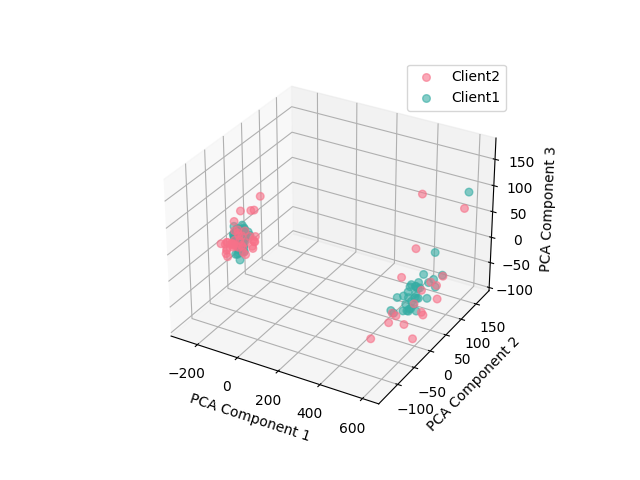

In [10]:
# Visualizing the latest data readiness report stored in ./output
import glob
from IPython.core.display import display, HTML

# Find all matching files
files = glob.glob("./output/data_readiness_report*.html")

# Get the latest file by modification time
latest_file = max(files, key=os.path.getmtime)

# Read and display the latest report
with open(latest_file, "r") as f:
    html_content = f.read()

display(HTML(html_content))

### 4. Activate the CADRE module to enforce remedies

Now let's set the `remedy_action` to `True` to enforce the remedial action defined in the CADRE module to fix the data-related issues of the clients. In this case, it is to remove noisy samples from the data.

In [23]:
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.remedy_action = True  # Set to False to disable automatic remedies


Similarly, you can define your own custom data readiness metrics, rules, and remedies to effectively assess the quality and readiness of your data before proceeding to the training phase.

### 5. Create a new communicator and start serving to clean data

Now, based on the new client agent with the data readiness and CADRE configurations, we can create a new server communicator and start serving. Here, since the `remedy_action` is set to `True`, the client data will be evaluated and remedial action will be performed to remove the noisy samples from the client's data.

In [24]:
import socket
from appfl.comm.grpc import serve
from appfl.comm.grpc import GRPCServerCommunicator

# Start the gRPC server communicator
communicator = GRPCServerCommunicator(
    server_agent,
    logger=server_agent.logger,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

#Getting the private IP address of the server
hostname = socket.gethostname()
private_ip = socket.gethostbyname(hostname)
print(f"\n\n✅ Replace server_uri with below in client notebook: {private_ip}:50051")

serve(
    communicator,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)



✅ Replace server_uri with below in client notebook: 192.168.1.121:50051


appfl: ✅[2025-06-26 13:56:21,635 server]: Received GetConfiguration request from client Client2
appfl: ✅[2025-06-26 13:56:24,208 server]: Received InvokeCustomAction get_data_readiness_report request from client Client2
appfl: ✅[2025-06-26 13:56:38,156 server]: Received GetConfiguration request from client Client1
appfl: ✅[2025-06-26 13:56:42,454 server]: Received InvokeCustomAction get_data_readiness_report request from client Client1
appfl: ✅[2025-06-26 13:56:42,559 server]: Data readiness report saved as HTML: ./output/data_readiness_report_34.html
appfl: ✅[2025-06-26 13:56:42,561 server]: Received InvokeCustomAction close_connection request from client Client2
appfl: ✅[2025-06-26 13:56:48,917 server]: Terminating the server ...


appfl: ✅[2025-06-23 21:50:41,592 server]: Received InvokeCustomAction close_connection request from client Client1
appfl: ✅[2025-06-23 21:50:41,593 server]: Received InvokeCustomAction close_connection request from client Client2
appfl: ✅[2025-06-23 21:50:42,353 server]: Terminating the server ...


Now let's visualize the data readiness report after the remedial actions were taken to remove the noisy samples as defined in the CADRE module

Data Range,Data Shape,Sample Size,Specified Metrics
"{'max': 5.23, 'min': -1.05}","(18, 1, 48, 60, 48)",18,{'mean': 1.0}
"{'max': 4.29, 'min': -1.15}","(44, 1, 48, 60, 48)",44,{'mean': 1.0}

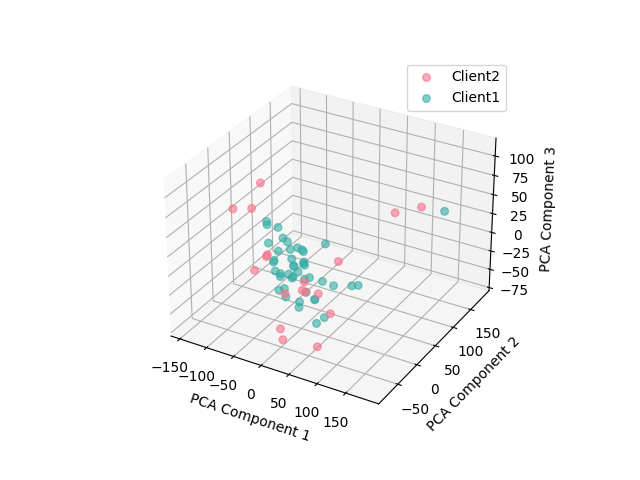

In [25]:
# Visualizing the latest data readiness report stored in ./output
import glob
from IPython.core.display import display, HTML

# Find all matching files
files = glob.glob("./output/data_readiness_report*.html")

# Get the latest file by modification time
latest_file = max(files, key=os.path.getmtime)

# Read and display the latest report
with open(latest_file, "r") as f:
    html_content = f.read()

display(HTML(html_content))

### 5. Create a new communicator and start serving to data after cleaning

Now, let's train after the data is cleaned

In [28]:
import socket
from appfl.comm.grpc import serve
from appfl.comm.grpc import GRPCServerCommunicator

# Start the gRPC server communicator
communicator = GRPCServerCommunicator(
    server_agent,
    logger=server_agent.logger,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

#Getting the private IP address of the server
hostname = socket.gethostname()
private_ip = socket.gethostbyname(hostname)
print(f"\n\n✅ Replace server_uri with below in client notebook: {private_ip}:50051")

serve(
    communicator,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)



✅ Replace server_uri with below in client notebook: 192.168.1.121:50051


appfl: ✅[2025-06-26 13:58:06,701 server]: Received GetGlobalModel request from client Client2
appfl: ✅[2025-06-26 13:58:11,090 server]: Received GetGlobalModel request from client Client2
appfl: ✅[2025-06-26 13:58:21,478 server]: Received GetGlobalModel request from client Client1
appfl: ✅[2025-06-26 13:58:30,032 server]: Received GetGlobalModel request from client Client1
appfl: ✅[2025-06-26 13:59:57,737 server]: Received UpdateGlobalModel request from client Client2
appfl: ✅[2025-06-26 13:59:57,741 server]: Received the following meta data from Client2:
{'pre_val_accuracy': 0.46323132514953613,
 'pre_val_loss': 0.5367775360743204,
 'round': 1,
 'val_accuracy': 0.5998205542564392,
 'val_loss': 0.40104875648230837}
appfl: ✅[2025-06-26 14:00:16,137 server]: Received UpdateGlobalModel request from client Client1
appfl: ✅[2025-06-26 14:00:16,138 server]: Received the following meta data from Client1:
{'pre_val_accuracy': 0.46323132514953613,
 'pre_val_loss': 0.5367775360743204,
 'round': 

appfl: ✅[2025-06-23 21:50:41,592 server]: Received InvokeCustomAction close_connection request from client Client1
appfl: ✅[2025-06-23 21:50:41,593 server]: Received InvokeCustomAction close_connection request from client Client2
appfl: ✅[2025-06-23 21:50:42,353 server]: Terminating the server ...
